## Methodology

- Train an autoencoder on all of the data available to be able to reconstruct any image with an identity
- accrue an average representation of all of the vangogh images in the latent space of this autoencoder
- accrue an average representation of all NON vangogh images in the latent space of the autoencoder

- v1
    - find the common values between all vangogh images and then take a weighted sum between that and the latent space of an arbitrary image
- v2
    - find the difference between the average vangogh image and the average image and then take a weighted sum between that and the latent space of an arbitrary image

## Version 1

In [1]:
import os
import PIL
import time
import imageio
import numpy as np
import tensorflow as tf
import tensorflow.data as tfd
import matplotlib.pyplot as pt

from glob import glob
from tqdm import tqdm
from typing import Iterable, List, Tuple, Any

In [2]:
def list_files(directory: str, search: Iterable) -> List[str]:
    """
    list files
    """
    if isinstance(search, str):
        search = [search]

    output: List[str] = []
    for term in search:
        for filepath in glob(os.path.join(directory, term)):
            output.append(filepath)

    return output

In [3]:
def load_random_image(directory: str, search: Iterable) -> np.ndarray:
    filepaths = list_files(directory, search)
    rand_index = np.random.randint(0, high=len(filepaths))
    return np.asarray(PIL.Image.open(filepaths[rand_index]))

## Dataset
- Train: 8868 images
- Test: 1697

In [4]:
data_dir = 'data'
random_image_dir = os.path.join(data_dir, 'random_images')
vangogh_image_dir = os.path.join(data_dir, 'vangogh_images')

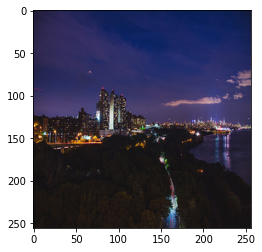

In [5]:
pt.imshow(load_random_image(random_image_dir, "*.jpg"))

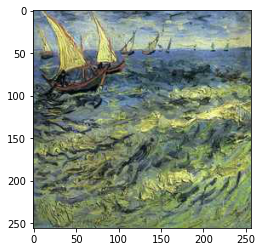

In [6]:
pt.imshow(load_random_image(vangogh_image_dir, "*.jpg"))

## Time to define the data generators

In [7]:
BATCH_SIZE = 16
BUFFER_SIZE = 64
DATASET_SIZE = len(list_files(random_image_dir, "*.jpg")) + len(list_files(vangogh_image_dir, "*.jpg"))

In [8]:
dgen_params = dict(
    rescale           =  1./255,
    shear_range       =  0.0,
    zoom_range        =  0.0,
    horizontal_flip   =  True,
    brightness_range  =  (0.95, 1.2),
    validation_split = 0.2,
)

gen_params = dict(
    target_size       =  (256, 256),
    batch_size        =  BATCH_SIZE,
    color_mode        =  'rgb',
    class_mode        =  'binary',
)

In [9]:
dgen = tf.keras.preprocessing.image.ImageDataGenerator(
    **dgen_params
)

train_gen = dgen.flow_from_directory(
    data_dir, 
    subset="training",
    **gen_params,
)

val_gen = dgen.flow_from_directory(
    data_dir, 
    subset="validation",
    **gen_params,
)

Found 8452 images belonging to 3 classes.
Found 2112 images belonging to 3 classes.


In [10]:
train_ds = tfd.Dataset.from_generator(lambda: train_gen, (tf.float32, tf.int32))
val_ds = tfd.Dataset.from_generator(lambda: val_gen, (tf.float32, tf.int32))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


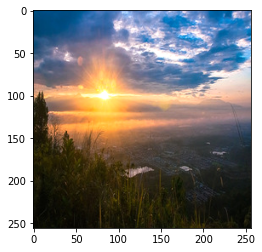

In [11]:
for img, label in train_ds.take(1).as_numpy_iterator():
    print(label)
    pt.imshow(img[0, ...])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


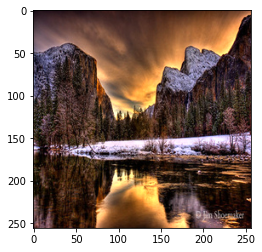

In [12]:
for img, label in val_ds.take(1).as_numpy_iterator():
    print(label)
    pt.imshow(img[0, ...])

## At this point, we know that our train and val generators contain our images which are labeled 1 for a random image and 2 for a vangogh image

In [211]:
from tensorflow.keras import layers
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dense, Reshape, LeakyReLU, Dropout, Flatten, Add

def downsampler_unit(input_tensor, num_features, filter_shape, strides_shape, padding, bias, max_pooling: bool = False):
    layer1 = Conv2D(num_features, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(input_tensor)
    layer2 = Conv2D(num_features, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(layer1)
    layer3 = Conv2D(num_features, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(layer2)
    layer4 = Conv2D(num_features, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(layer3)
    layer4 = InstanceNormalization()(layer4)
    if max_pooling: 
        layer4 = MaxPool2D((2, 2))(layer4)
    layer4 = LeakyReLU()(layer4)

    return tf.keras.models.Model(inputs=input_tensor, outputs=layer4)

def upsampler_unit(input_tensor, scaling, filter_shape, strides_shape, padding, bias, instance_norm: bool = False):
    layer1 = Conv2DTranspose(scaling, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(input_tensor)
    layer2 = Conv2DTranspose(scaling, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(layer1)
    if instance_norm:
        layer2 = InstanceNormalization()(layer2)
    layer2 = LeakyReLU()(layer2)
    
    return tf.keras.models.Model(inputs=input_tensor, outputs=layer2)

def latent_space_unit(input_tensor, latent_dim, dropout_pct):
    dropout = Dropout(dropout_pct)(input_tensor)
    flatten = Flatten()(dropout)
    latent_space = Dense(latent_dim)(flatten)

    return tf.keras.models.Model(inputs=input_tensor, outputs=latent_space)

class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.multiplier = 200
        self.latent_dim = 256*self.multiplier

        self.encoder_input = Input(shape=(256, 256, 3))
        self.ds1 = downsampler_unit(self.encoder_input, 3, (10, 10), (1, 1), 'same', False, False)
        self.ds2 = downsampler_unit(Input(shape=self.ds1.output_shape[1:]), 9, (10, 10), (1, 1), 'same', True, True)
        self.ds3 = downsampler_unit(Input(shape=self.ds2.output_shape[1:]), 18, (5, 5), (2, 2), 'same', True, False)
        self.ds4 = downsampler_unit(Input(shape=self.ds3.output_shape[1:]), 27, (3, 3), (1, 1), 'same', True, False)
        
        self.latent_space = latent_space_unit(Input(shape=(self.ds4.output_shape[1:])), self.latent_dim, 0.3)
        
        self.decoder_input = Input(shape=(16, 16, self.multiplier))
        self.up1 = upsampler_unit(self.decoder_input, 9, (3, 3), (1, 1), 'same', True, False)
        self.up2 = upsampler_unit(Input(shape=self.up1.output_shape[1:]), 3, (3, 3), (4, 4), 'same', True, False)
        self.up3 = upsampler_unit(Input(shape=self.up2.output_shape[1:]), 3, (3, 3), (2, 2), 'same', True, False)

    def plot_model_graph(self):
        tf.keras.utils.plot_model(
            tf.keras.models.Model(
                inputs=self.encoder_input, 
                outputs=self.call(self.encoder_input)), 
            'functional_components.png', 
            expand_nested=True, 
            show_shapes=True)
    
    def call(self, image_batch):
        layer1 = self.ds1(image_batch)
        layer2 = self.ds2(layer1)
        layer3 = self.ds3(layer2)
        layer4 = self.ds4(layer3)
        
        latent_space = self.latent_space(layer4)
                                              
        reshape = Reshape((16, 16, self.multiplier))(latent_space)
        layer5 = self.up1(reshape)
        layer6 = self.up2(layer5)
        skip_connection1 = Add()([layer1, layer6])
        layer7 = self.up3(skip_connection1)
        
        
        return layer7

In [212]:
autoencoder = Autoencoder()

In [213]:
autoencoder.build(input_shape=(BATCH_SIZE, 256, 256, 3))
autoencoder.summary()

Model: "autoencoder_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_113 (Functional)       (None, 256, 256, 3)       3606      
_________________________________________________________________
model_114 (Functional)       (None, 128, 128, 9)       27054     
_________________________________________________________________
model_115 (Functional)       (None, 8, 8, 18)          28458     
_________________________________________________________________
model_116 (Functional)       (None, 8, 8, 27)          24219     
_________________________________________________________________
model_117 (Functional)       (None, 51200)             88524800  
_________________________________________________________________
model_118 (Functional)       (None, 16, 16, 9)         16947     
_________________________________________________________________
model_119 (Functional)       (None, 256, 256, 3)    

In [214]:
autoencoder.plot_model_graph()

In [16]:
mse = tf.keras.losses.MSE

In [17]:
def autoencoder_loss(original_image, decoded_image):
    return mse(original_image, decoded_image)

In [18]:
autoencoder_optimizer = tf.keras.optimizers.RMSprop(lr=1e-5)

In [19]:
checkpoint_dir: str = 'autoencoder_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(autoencoder_optimizer=autoencoder_optimizer,
                                    autoencoder=autoencoder,
                                )

In [20]:
EPOCHS = 10
EPOCH_BATCHES = 2000

In [21]:
@tf.function
def train_step(images):
    with tf.GradientTape() as grad:
        autoencoded_images = autoencoder(images, training=True)
        loss = autoencoder_loss(images, autoencoded_images)
    gradients_of_autoencoder = grad.gradient(loss, autoencoder.trainable_variables)
    autoencoder_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))

In [22]:
def train(images, epochs, epoch_batches):
    with tqdm(total=epochs*epoch_batches) as pbar:
        for epoch in range(epochs):
            start = time.time()
            for image, _ in images.take(epoch_batches):
                train_step(image)
                pbar.update(1)
                
        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print(f"Time for epoch {epoch} is {time.time()-start}")

In [23]:
train(train_ds, EPOCHS, EPOCH_BATCHES)

100%|██████████| 20000/20000 [19:31<00:00, 17.07it/s]

Time for epoch 9 is 120.99335813522339


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


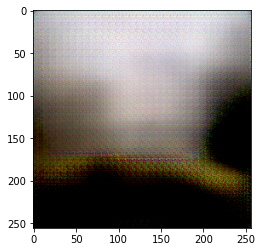

In [24]:
for img, _ in train_ds.take(1).as_numpy_iterator():
    pt.imshow(autoencoder(img[0, ...].reshape(1, *img[0,...].shape))[0, ...])

In [25]:
autoencoder.save('model_200', save_format='tf')

INFO:tensorflow:Assets written to: model_200/assets


In [26]:
newauto = tf.keras.models.load_model('model_200')

In [32]:
im = None
for img, _ in train_ds.take(1).as_numpy_iterator():
    im = img[0, ...].reshape(1, *img[0,...].shape)
#     pt.imshow(newauto(img[0, ...].reshape(1, *img[0,...].shape))[0, ...])

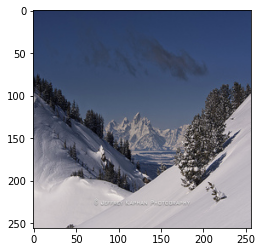

In [33]:
pt.imshow(im[0, ...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


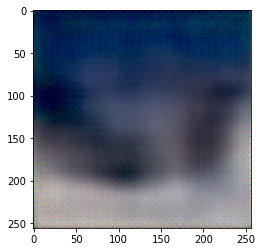

In [34]:
pt.imshow(autoencoder(im[0, ...].reshape(1, *im[0,...].shape))[0, ...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


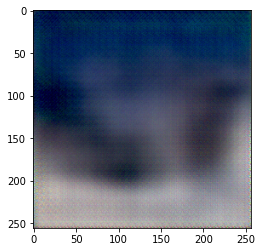

In [35]:
pt.imshow(newauto(im[0, ...].reshape(1, *im[0,...].shape))[0, ...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


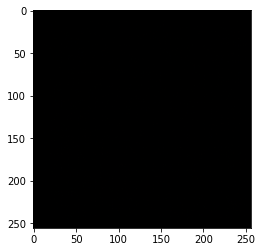

In [31]:
    pt.imshow(Autoencoder()(im[0, ...].reshape(1, *im[0,...].shape))[0, ...])